# Running experiments

In this notebook we perform model selection and hyperparameter search for the classification model. The ultimate goal of this survey is to keep track of already explored configurations and how they perform, in order to select the best configuration for deployment later.

We use MLflow model tracking for such a purpose.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [1]:
import os

def set_directory(using_colab):
  """
  Set main directory to be just one level before the
  src and notebooks directories. It handles this differently depending whether
  we are in colab or local. If we are in colab we also mount the drive
  """

  if using_colab:

      if os.getcwd() == '/content':  # Starting folder by default

        # Mount drive if run function for the first time
        from google.colab import drive
        drive.mount('/content/drive')

      # Change dir to where project is located
      os.chdir(f"/content/drive/MyDrive/covision/classification")
  else:
    if 'models_seg' in os.listdir(os.getcwd()) or 'models_cla' in os.listdir(os.getcwd()): # Already in desired location
      pass
    else:
      os.chdir('../')  # Go back one level (from notebooks_seg to segmentation or classification folder)

  cwd = os.getcwd()
  print(f'Current working directory: {cwd}\n')

  return cwd

In [2]:
import sys
import os
import yaml
import argparse

# Check whether we are in colab or local
using_colab = True if 'google.colab' in sys.modules else False
# Set current working directory to be one level above the src folder
cwd = set_directory(using_colab)
# Read arguments from dict and store them as Namespace
if 'config_cla.yaml' in os.listdir(cwd):
    with open('config_cla.yaml', 'r') as f:
        args = argparse.Namespace(**yaml.safe_load(f))
    # Update directories
    args.data_dir = os.path.join(cwd, args.data_dir)
    args.save_path = os.path.join(cwd, args.save_path)
    
# Add src folder and one level above to PYTHONPATH
sys.path.insert(0, 'src_cla/')
sys.path.insert(0, './../')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: /home/guybrush/Tomaco/covision/classification



## Setup server and define experiment

In [3]:
if using_colab:
  os.system("pip3 install pyngrok")  # Create remote tunnel using ngrok.com to allow local port access
  os.system("pip3 install mlflow")

import mlflow

from utils.mlflow_utils import initiate_mlflow_server, create_mlflow_experiment

if 'models_cla' in os.listdir(os.getcwd()):
  os.chdir('models_cla')

In [4]:
# Initiate mlflow sever to default location http://127.0.0.1:5000
initiate_mlflow_server(using_colab)

# Experiment name
experiment_name = "Prueba"#"Resnet18_Full_Aconag"
# Experiment description that will appear in the UI
experiment_description = (
    "This is the membrane classifier project.\n"
    "This experiment uses the simple ResNet18 architecture with a 1-layer output for binary classification.\n"
    "This experiment uses the full aconag trainset for trainning."
)

# Searchable tags that define characteristics of the different runs inside this experiment.
experiment_tags = {
    "project_name": "membrane_classifier",
    "architecture": "resnet18",
    "data": "full_aconag",
    "mlflow.note.content": experiment_description,
}

# Create experiment
experiment_id = create_mlflow_experiment(experiment_name, tags=experiment_tags)

# Set experiment
experiment = mlflow.set_experiment(experiment_name=experiment_name)

[2024-03-28 12:02:57 +0100] [13474] [INFO] Starting gunicorn 21.2.0
[2024-03-28 12:02:57 +0100] [13474] [INFO] Listening at: http://127.0.0.1:5000 (13474)
[2024-03-28 12:02:57 +0100] [13474] [INFO] Using worker: sync
[2024-03-28 12:02:57 +0100] [13476] [INFO] Booting worker with pid: 13476
[2024-03-28 12:02:57 +0100] [13477] [INFO] Booting worker with pid: 13477
[2024-03-28 12:02:57 +0100] [13478] [INFO] Booting worker with pid: 13478
[2024-03-28 12:02:57 +0100] [13479] [INFO] Booting worker with pid: 13479


## Train, evaluate and MLflow run

we now train a model with a specific dataset and set of hyperparameters, evaluate it on a validation set and log the relevant parameters and characteristics using MLflow 

In [7]:
from model_train_cla import TrainerClassification
from model_evaluate_cla import EvalClassification
from utils_cla.visualization import plot_metrics
from model_cla import ClassificationModel

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


In [25]:
# Parameters and hyperparameters
parameters = {
    'kit_id': ['aconag'],
    'val_set': 'val',
    'shots': [10],
    'seed': 42,
    'batch_size': 32,
    'num_workers': 0,
    'lr': 0.001,
    'weight_decay': 0.00001,
    'scheduler_step': None,
    'scheduler_gamma': None,
    'epochs': 5
}  

Using cpu device
Random seed set as 42
Loading data...
There are 10 membranes (20 zones) in the aconag kit(s) for train data mode
There are 53 membranes (106 zones) in the aconag kit(s) for val data mode


0it [00:00, ?it/s]

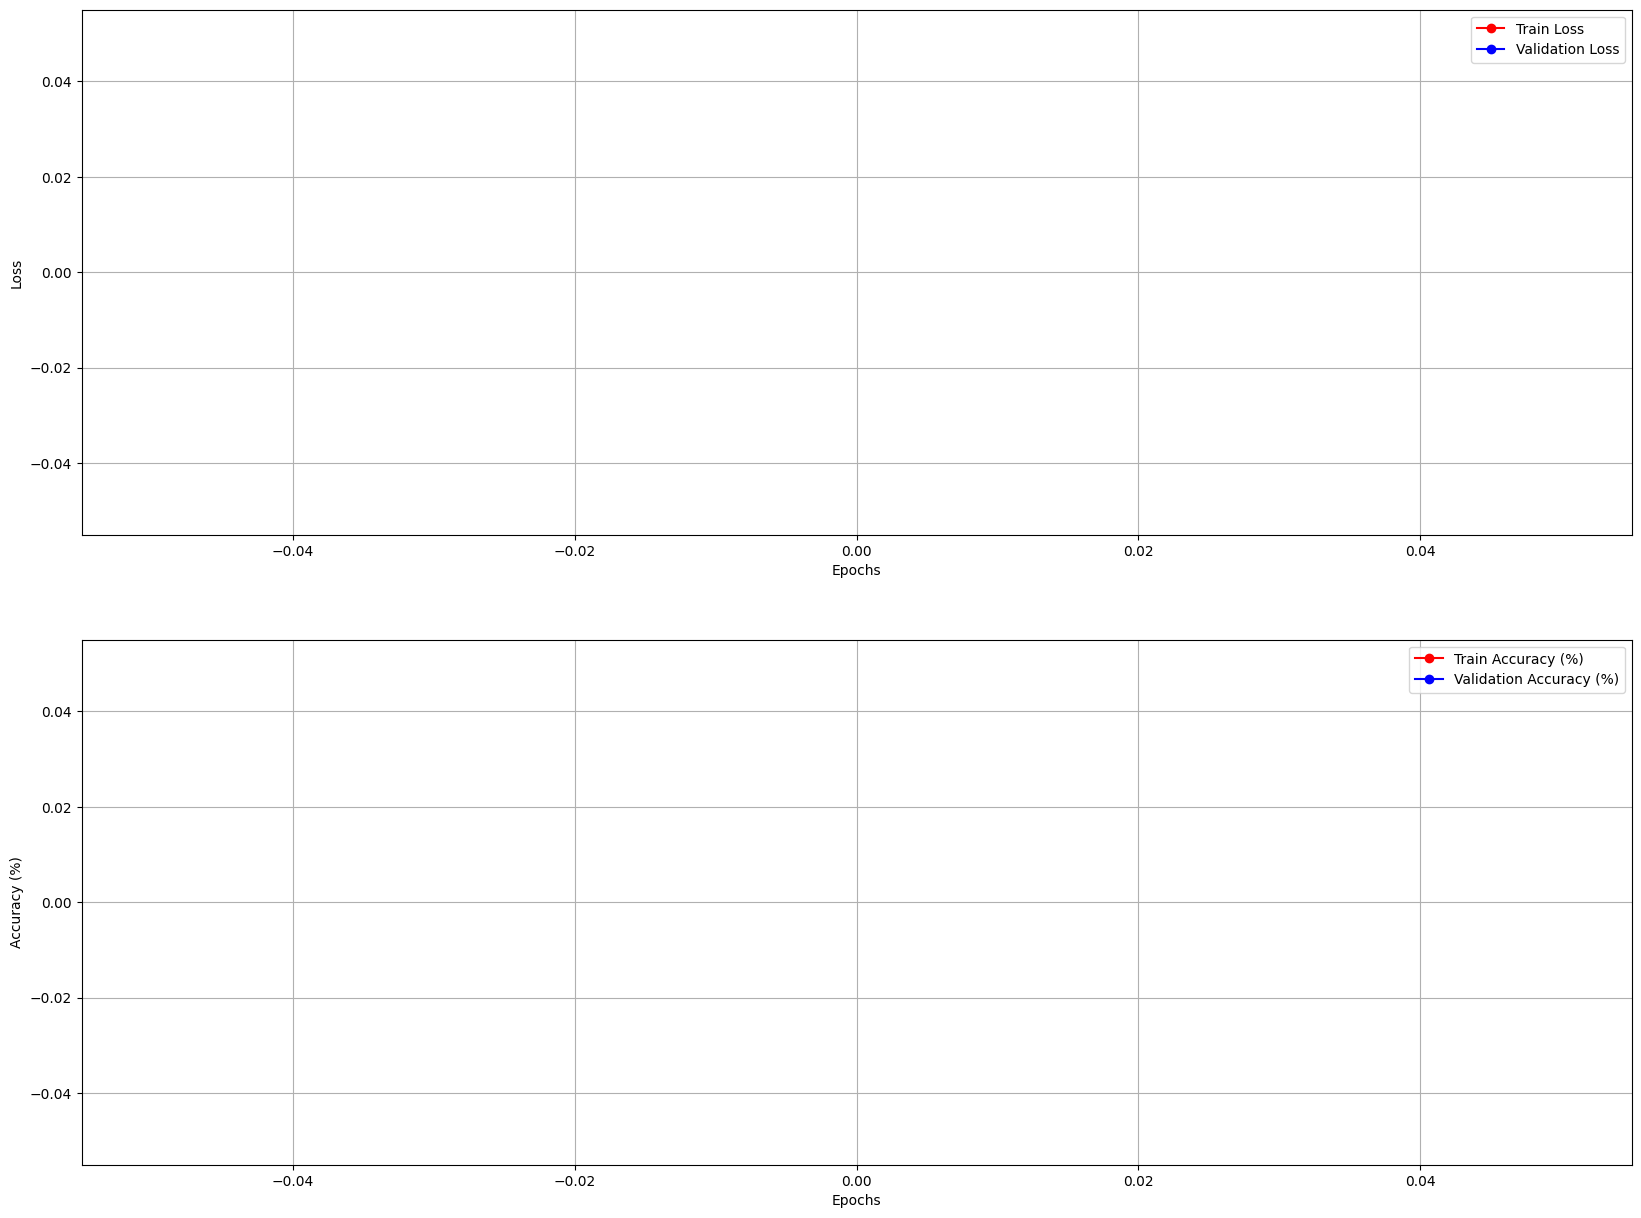

There are 205 membranes (410 zones) in the aconag kit(s) for train data mode


  0%|          | 0/13 [00:00<?, ?it/s]

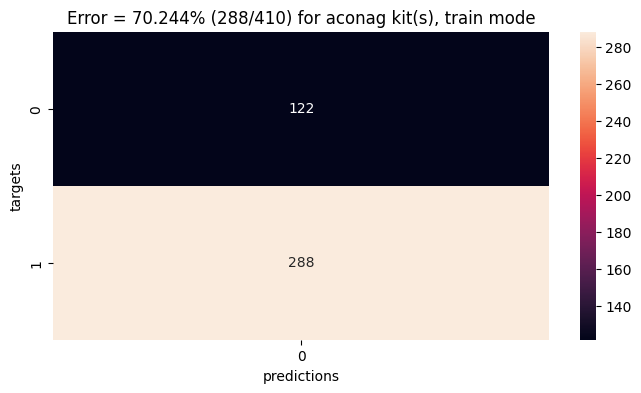

/home/guybrush/.local/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [26]:
# Train 
trainer = TrainerClassification(args, parameters)
trainer.train(save_model_bool=False)

# Plot metrics
plot_metrics(*trainer.get_metrics(), figsize=(20, 15))

# Evaluate best model on trainingset to get accuracy
tester = EvalClassification(args, model=trainer.best_model, device=None)
_, _, final_train_accuracy = tester.evaluate(kit_id=trainer.get_parameters['kit_id'], data_mode='train')

# Start MLflow run
with mlflow.start_run() as run:
    
    # Log hyperparameters
    mlflow.log_params(trainer.get_parameters)
    mlflow.log_params({'n_trainset': len(trainer.loader_train.dataset)*2,
                       'n_valset': len(trainer.loader_val.dataset)*2})

    # Log metrics
    mlflow.log_metric("best_validation_accuracy", trainer.best_accuracy)
    mlflow.log_metric("epoch_of_best_accuracy", trainer.best_epoch)
    mlflow.log_metric("best_train_accuracy", final_train_accuracy)
    
    # Log model
    mlflow.pytorch.log_model(pytorch_model=trainer.best_model, artifact_path='model')

## Evaluate on unseen data

When obtained the best model according to the validation set, we evaluate the model on unseen data such as test sets or other kits. We store the relevant parameters, metrics and figures as artifacts inside the `mlruns` folder.

The best model is also registered in the MLflow model registry to specify that such a model finished with the deployment stage. Currently, this registration mus be done manually using the MLflow ui.

In [87]:
# Load model from run_id
run_id = '5c6cc97eb120476ca464389843fcb000' # run.info.run_id
model = mlflow.pytorch.load_model(model_uri=f"runs:/{run_id}/model")

# Path to save evaluation artifacts
save_path = os.path.join(cwd, f'models_cla/mlruns/{experiment_id}/{run_id}/artifacts/model_evaluation')

In [88]:
tester = EvalClassification(args, model=model, device=None)

There are 66 membranes (132 zones) in the ['aconag'] kit(s) for test data mode


  0%|          | 0/5 [00:00<?, ?it/s]

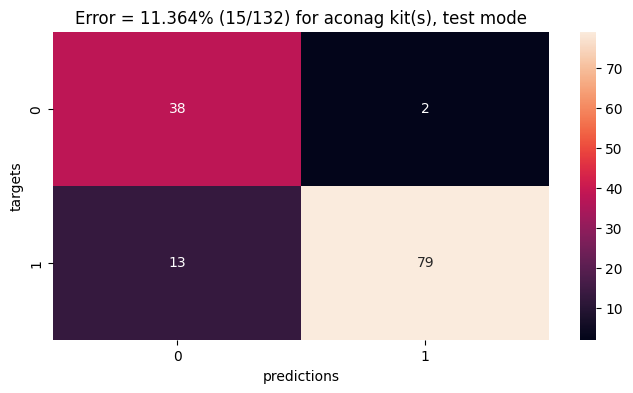

In [86]:
_, _, accuracy_test = tester.evaluate(kit_id=['aconag'], data_mode='test', save_bool=True, save_path=save_path)

There are 488 membranes (976 zones) in the ['deepblueag', 'paramountag'] kit(s) for all data mode


  0%|          | 0/31 [00:00<?, ?it/s]

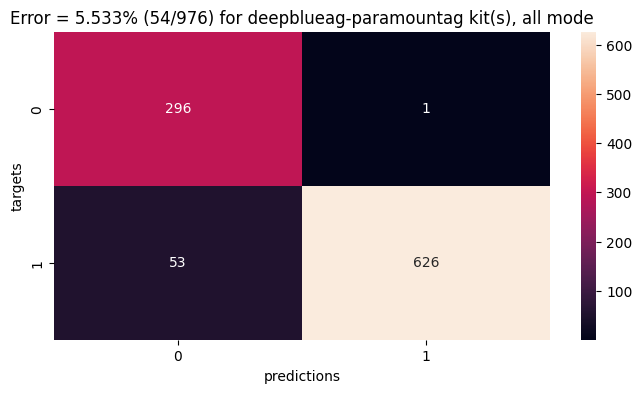

In [73]:
misclassified_zones, misclassified_df, other_kits_accuracy = tester.evaluate(kit_id=['deepblueag', 'paramountag'], 
                                                                             data_mode='all', 
                                                                             save_bool=True, 
                                                                             save_path=save_path)

There are 98 membranes (196 zones) in the ['deepblueag', 'paramountag'] kit(s) for test data mode


  0%|          | 0/7 [00:00<?, ?it/s]

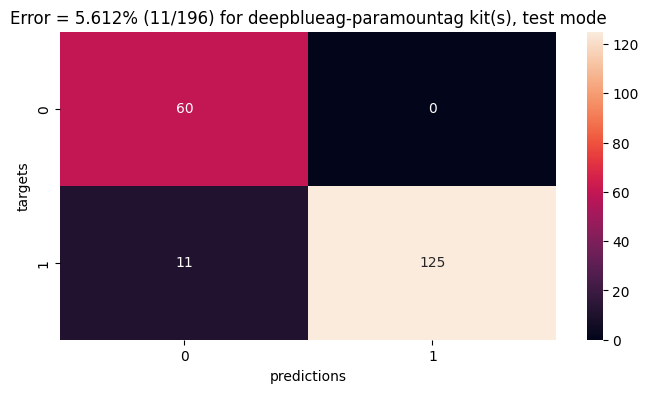

In [89]:
_ = tester.evaluate(kit_id=['deepblueag', 'paramountag'], data_mode='test', save_bool=True, save_path=save_path)

## Show misclassified examples

If desired, one can display the examples that were misclassified.

In [68]:
from utils_cla.visualization import show_zones

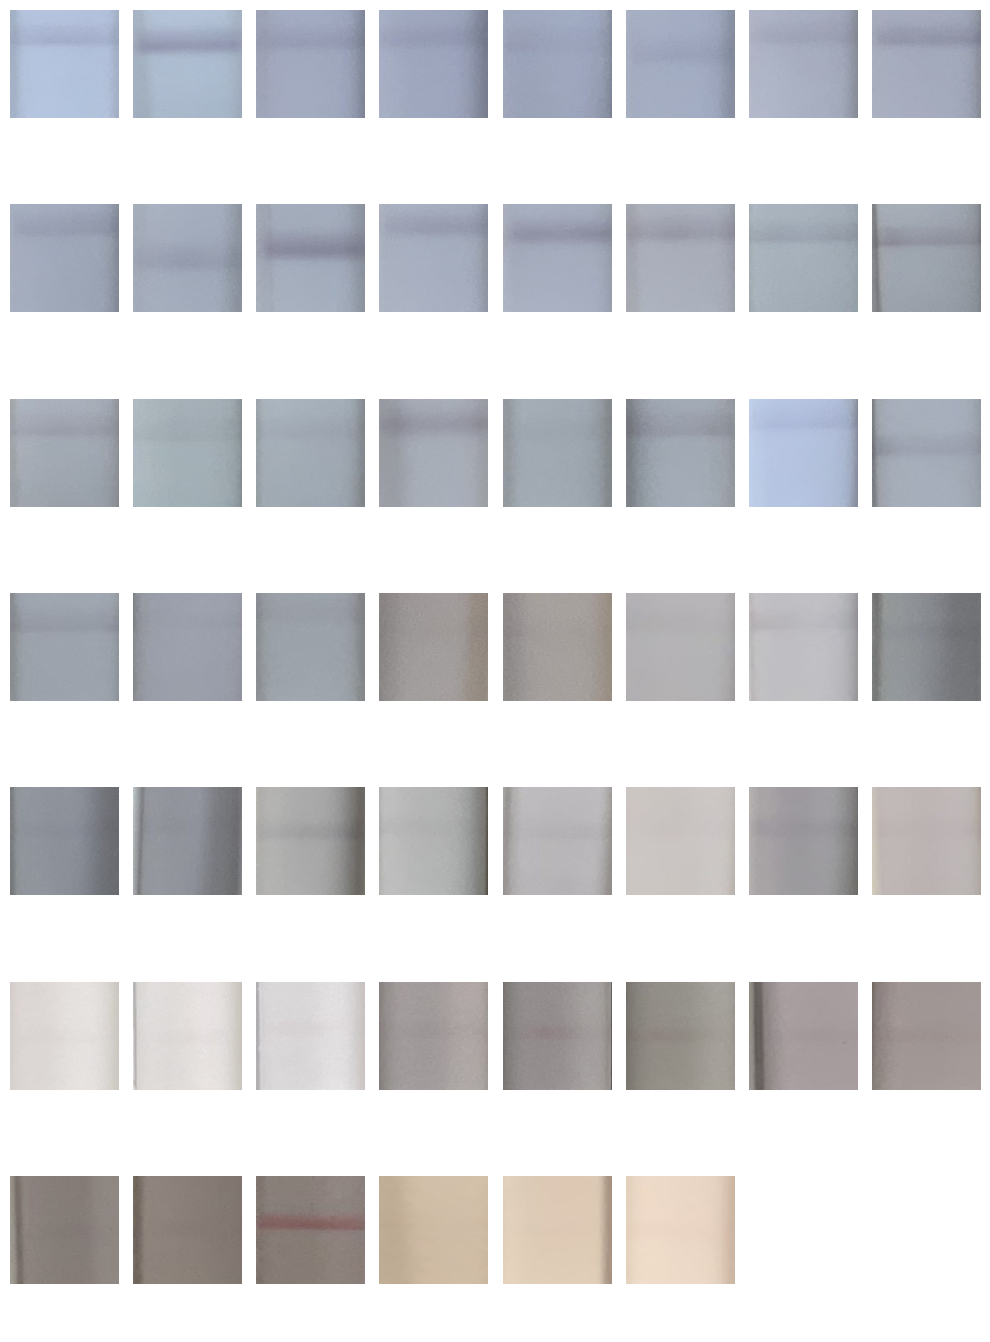

,zone_ndx,targets,predictions
filenames,,,
IMG_0028,1,1,0
IMG_0029,1,1,0
IMG_0033,1,1,0
IMG_0034,1,1,0
IMG_0035,1,1,0
IMG_0037,1,1,0
IMG_0039,1,1,0
IMG_0040,1,1,0
IMG_0042,1,1,0


In [69]:
show_zones(misclassified_zones, n_cols=8,  mean=tester.transform.mean, std=tester.transform.std)
misclassified_df